# Training a Classifier on Various Perturbed Crystal Types using GMMs

This tutorial describes how to set up a database of crystals relevant to identifying a variety of phases using the `ase` package and __rattling__. Rattling is the perturbation of crystals away from their highest symmetry configuration using some displacement distribution. Rattling thus emulates the effect of temperature without the expansion of the lattice. The atoms of the rattled crystals are then each transformed into feature vectors for classification. Classification is here carried out using a modified form of Gaussian Mixture Models (GMMs). Lastly, the classifier is evaluated for the different phases selected.

In [1]:
%matplotlib notebook
import numpy as np
from scipy import interpolate, spatial, stats, special
import itertools, warnings, copy
from ase.lattice.cubic import FaceCenteredCubic, SimpleCubicFactory
from ase.spacegroup import crystal
from ase.build import nanotube, graphene_nanoribbon
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import linear_model, utils, preprocessing
import sklearn
import atomtoolbox as atb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

E:\Programs\Anaconda3\envs\py35\lib\site-packages\ase\lattice\spacegroup.py:5: UserWarning: Moved to ase.spacegroup
  warnings.warn('Moved to ase.spacegroup')


## 1. Generating a Collection of Ideal Crystals

In [2]:
a0 = 3.52
L12 = atb.L12Factory()
size = (2,2,2)
atoms_gamma_prime = L12(directions=[[1,0,0],[0,1,0],[0,0,1]], size=size,
                          symbol=["Al","Ni"],pbc=(1,1,1),latticeconstant=a0)
atoms_dict = {"gamma_prime":atoms_gamma_prime}

a = 4.05
atoms_fccAl = crystal('Al', [(0,0,0)], spacegroup=225, cellpar=[a, a, a, 90, 90, 90],
                     size=size, pbc=(1,1,1))
atoms_dict["fccAl"] = atoms_fccAl

a = 2.87
atoms_bccFe = crystal('Fe', [(0,0,0)], spacegroup=229, cellpar=[a, a, a, 90, 90, 90],
                      size=size, pbc=(1,1,1))
atoms_dict["bccFe"] = atoms_bccFe

a = 3.21
c = 5.21
atoms_hcpMg = crystal('Mg', [(1./3., 2./3., 3./4.)], spacegroup=194,
                      cellpar=[a, a, c, 90, 90, 120], size=size, pbc=(1,1,1))
atoms_dict["hcpMg"] = atoms_hcpMg

a = 3.57
atoms_diamond = crystal('C', [(0,0,0)], spacegroup=227, cellpar=[a, a, a, 90, 90, 90],
                        size=size, pbc=(1,1,1))
atoms_dict["diamond"] = atoms_diamond

a = 5.64
atoms_NaCl = crystal(['Na', 'Cl'], [(0, 0, 0), (0.5, 0.5, 0.5)], spacegroup=225,
                     cellpar=[a, a, a, 90, 90, 90], size=size, pbc=(1,1,1))
atoms_dict["NaCl"] = atoms_NaCl

a = 4.6
c = 2.95
atoms_rutile = crystal(['Ti', 'O'], basis=[(0, 0, 0), (0.3, 0.3, 0.0)],
                spacegroup=136, cellpar=[a, a, c, 90, 90, 90], size=size, pbc=(1,1,1))
atoms_dict["rutile"] = atoms_rutile

a = 9.04
atoms_skutterudite = crystal(('Co', 'Sb'),
                       basis=[(0.25, 0.25, 0.25), (0.0, 0.335, 0.158)],
                       spacegroup=204, size=size, pbc=(1,1,1),
                       cellpar=[a, a, a, 90, 90, 90])
atoms_dict["skutterudite"] = atoms_skutterudite

## 2. Rattling Crystals

rattling  NaCl
rattling  bccFe
rattling  diamond
rattling  fccAl
rattling  gamma_prime
rattling  hcpMg
rattling  rutile
rattling  skutterudite
t_l_flat 21120
rpositions_flat 320, Natoms_flat 320 atoms total 21120, cells_flat 320, species_flat 320


<IPython.core.display.Javascript object>


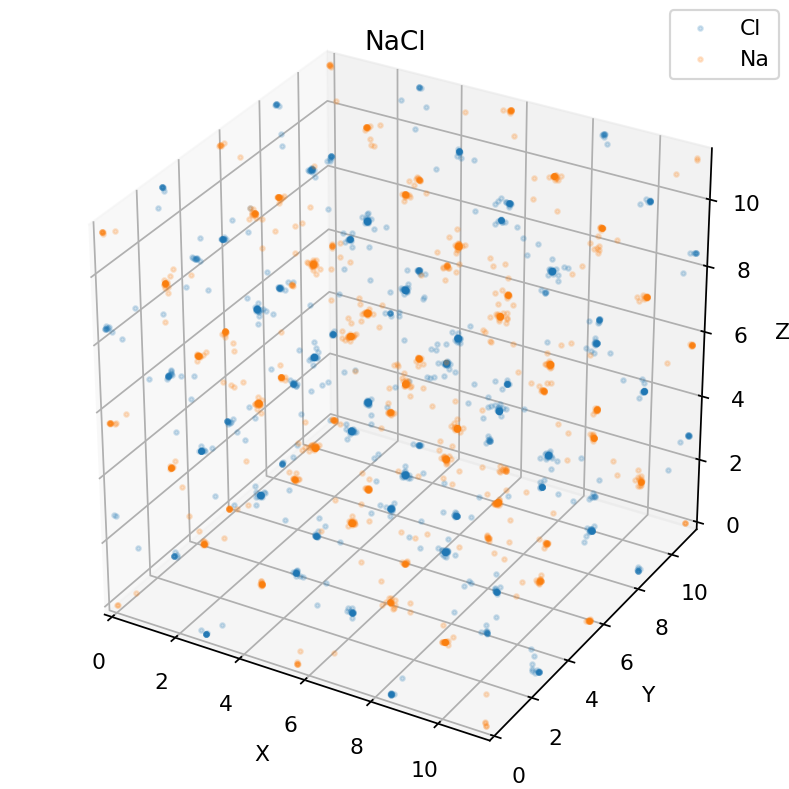

<IPython.core.display.Javascript object>


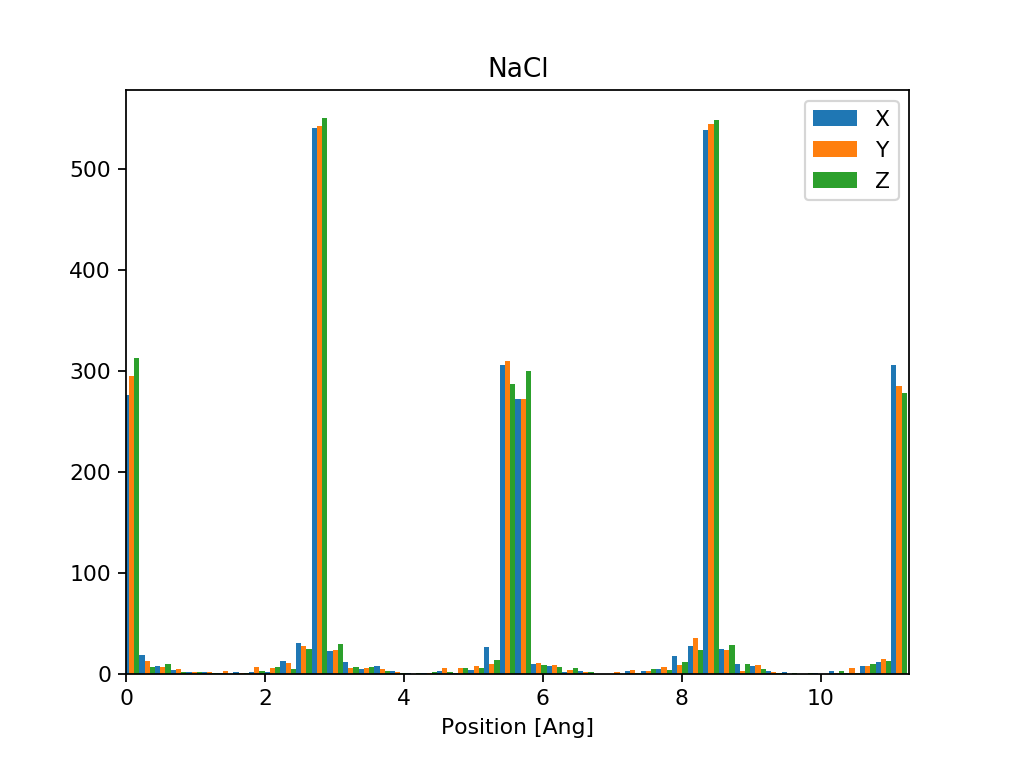

<IPython.core.display.Javascript object>


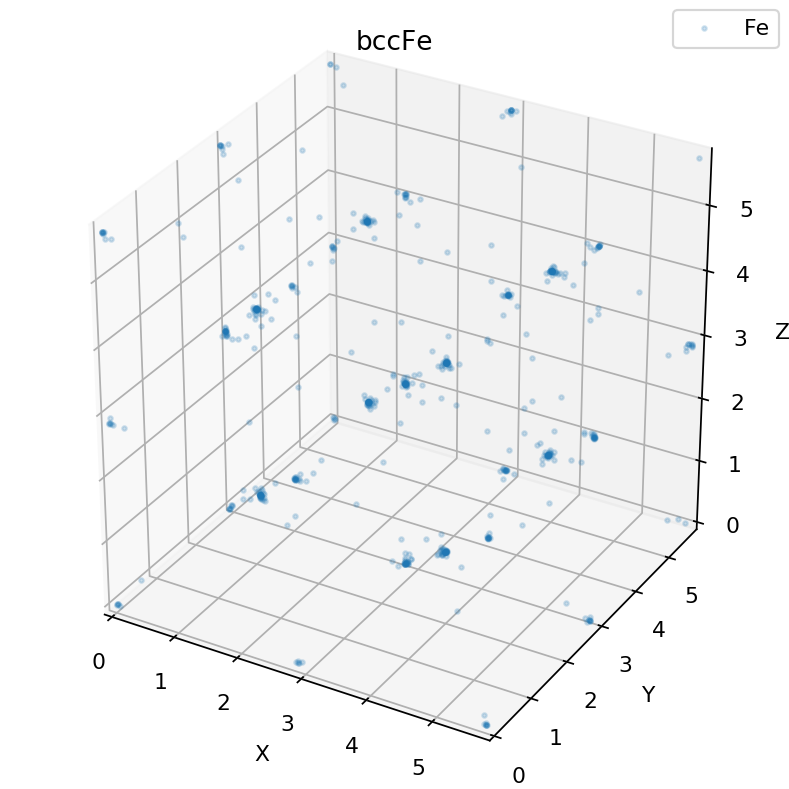

<IPython.core.display.Javascript object>


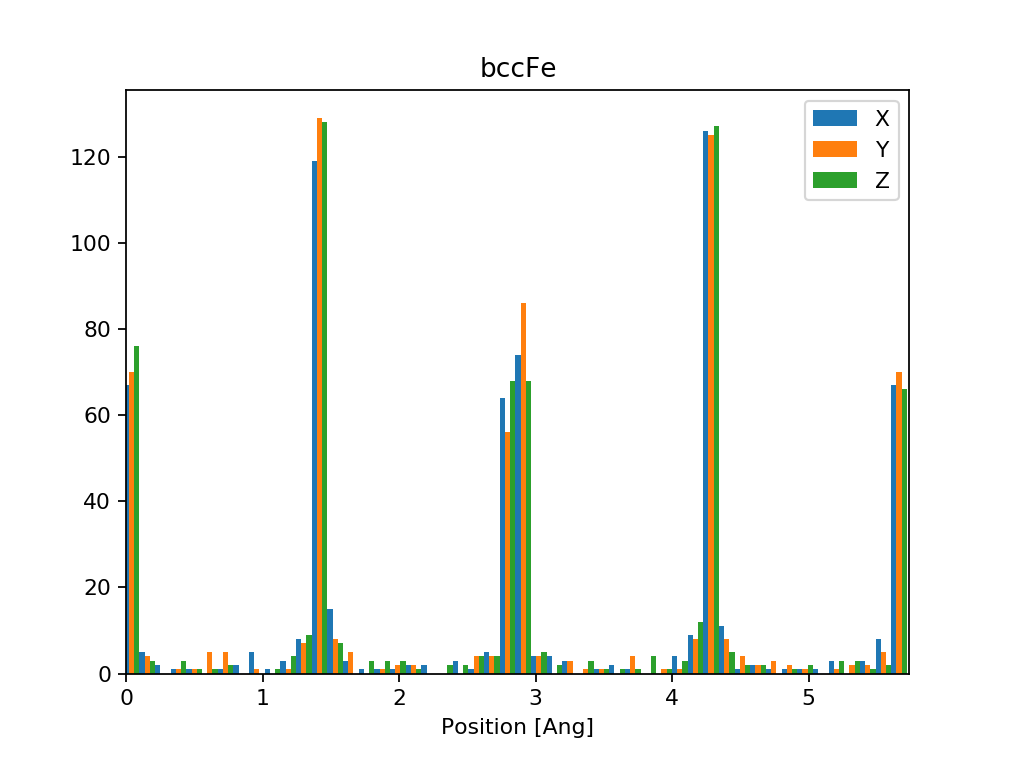

<IPython.core.display.Javascript object>


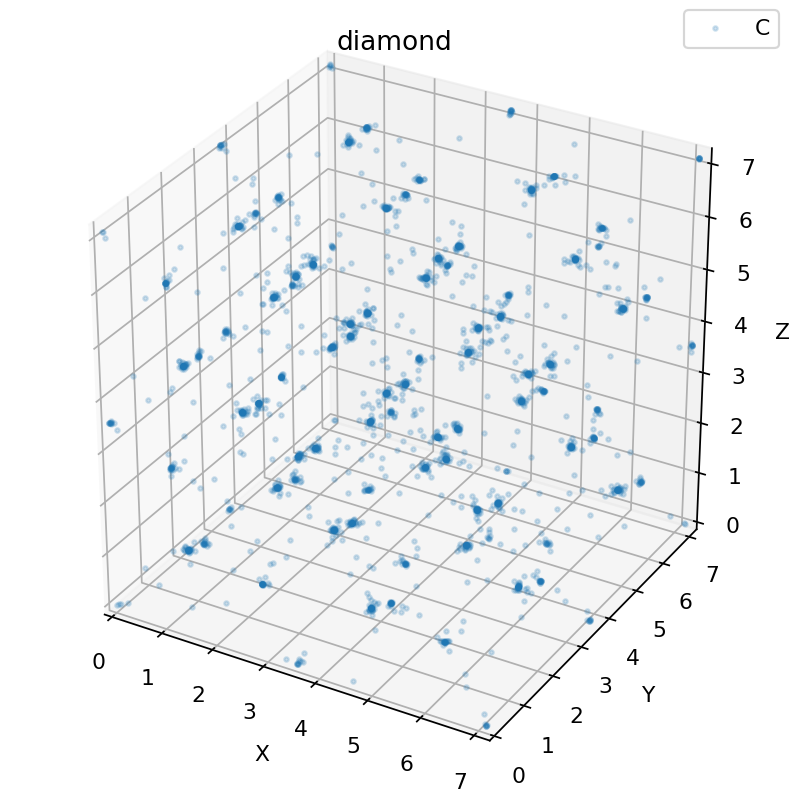

<IPython.core.display.Javascript object>


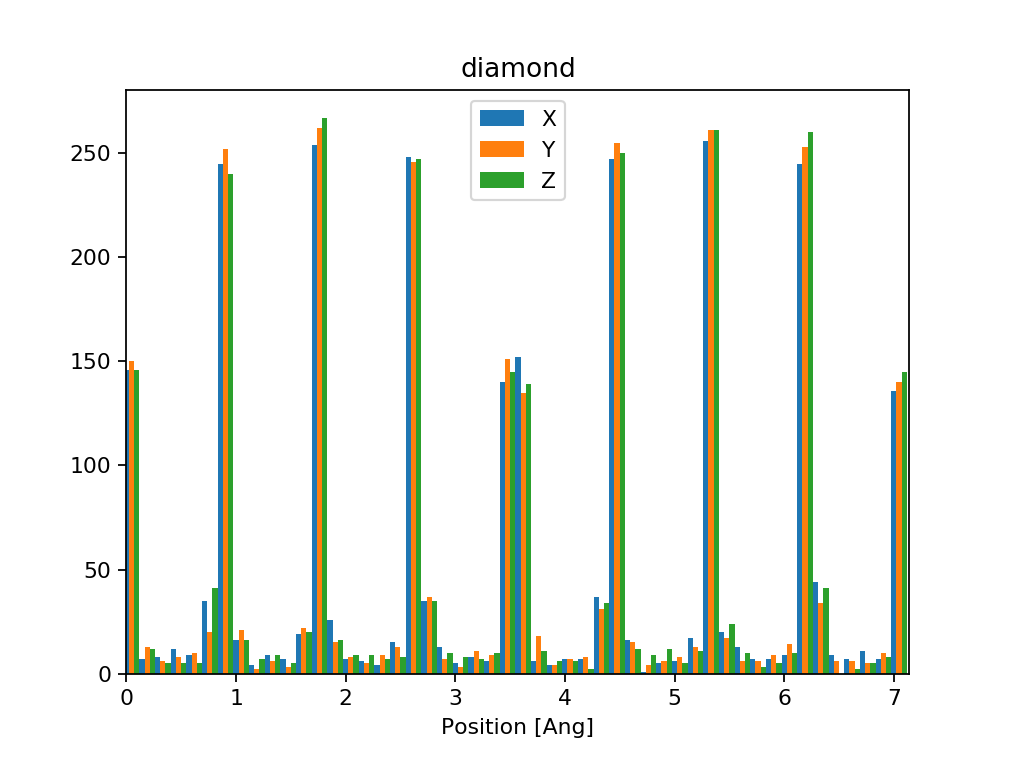

<IPython.core.display.Javascript object>


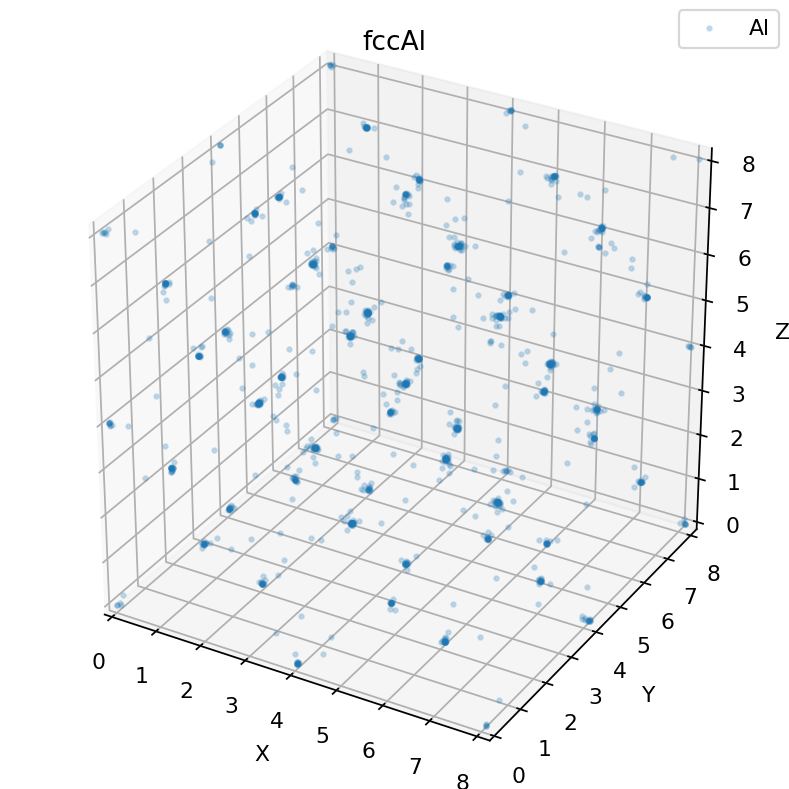

<IPython.core.display.Javascript object>


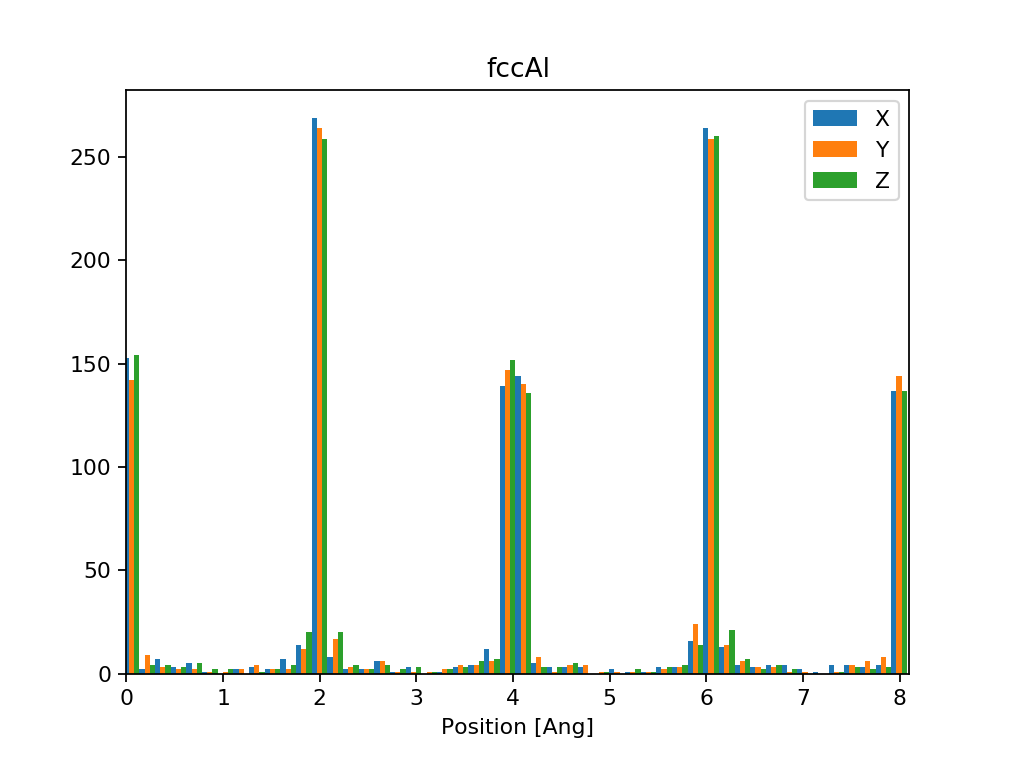

<IPython.core.display.Javascript object>


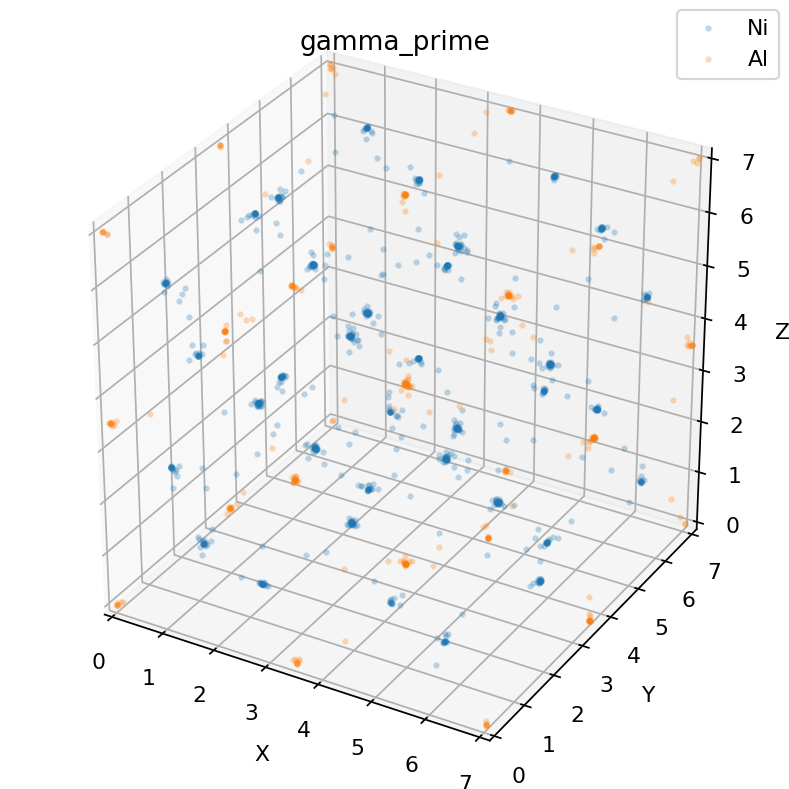

<IPython.core.display.Javascript object>


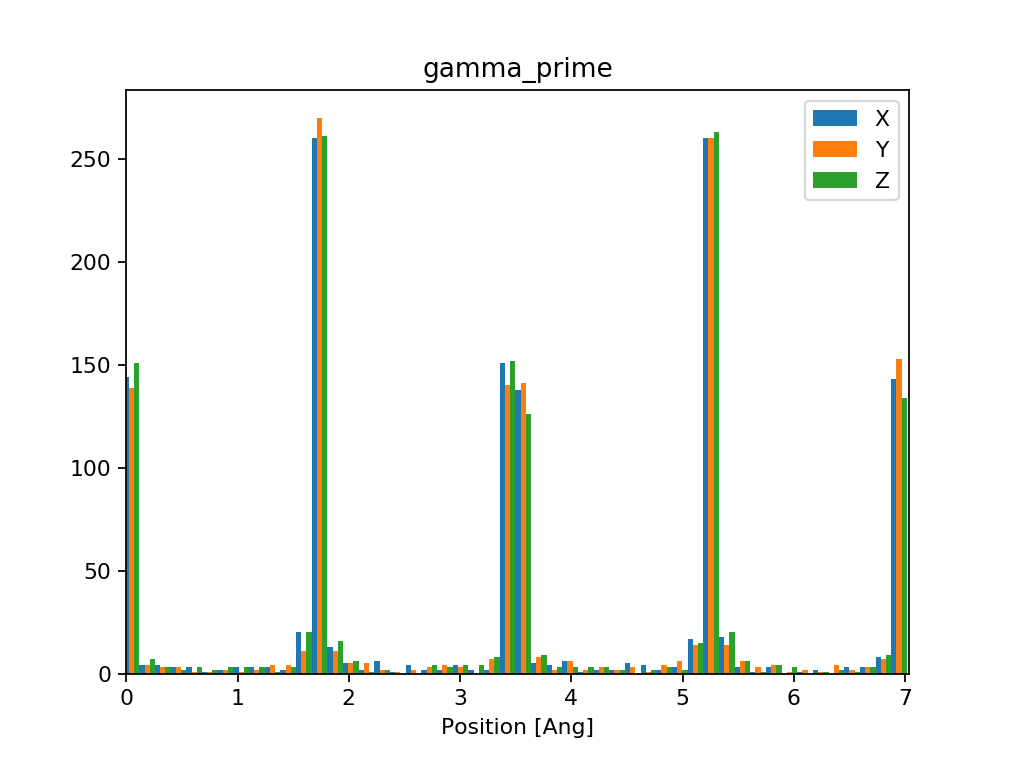

<IPython.core.display.Javascript object>


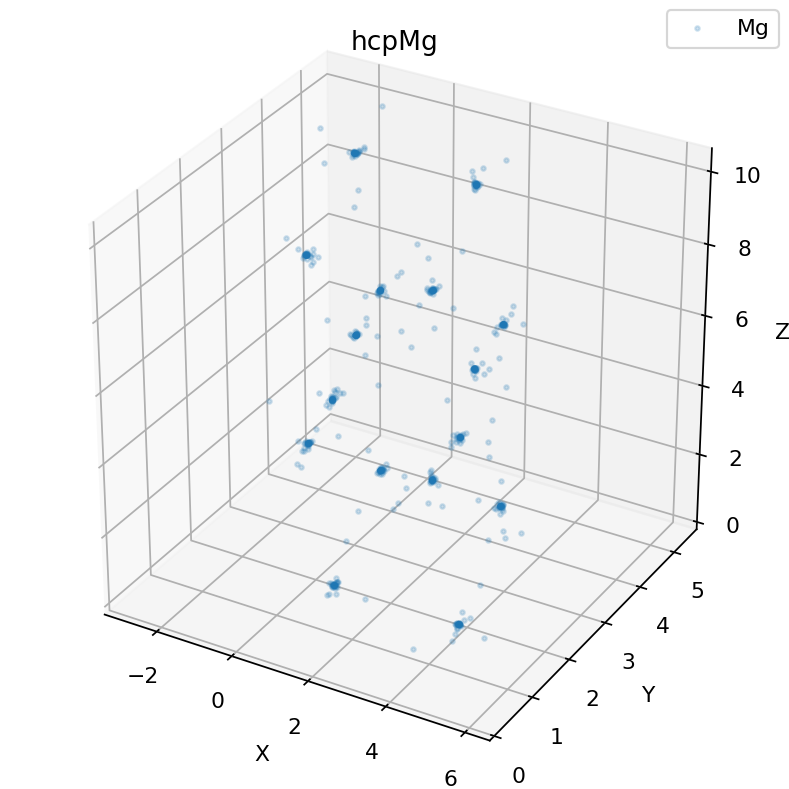

<IPython.core.display.Javascript object>


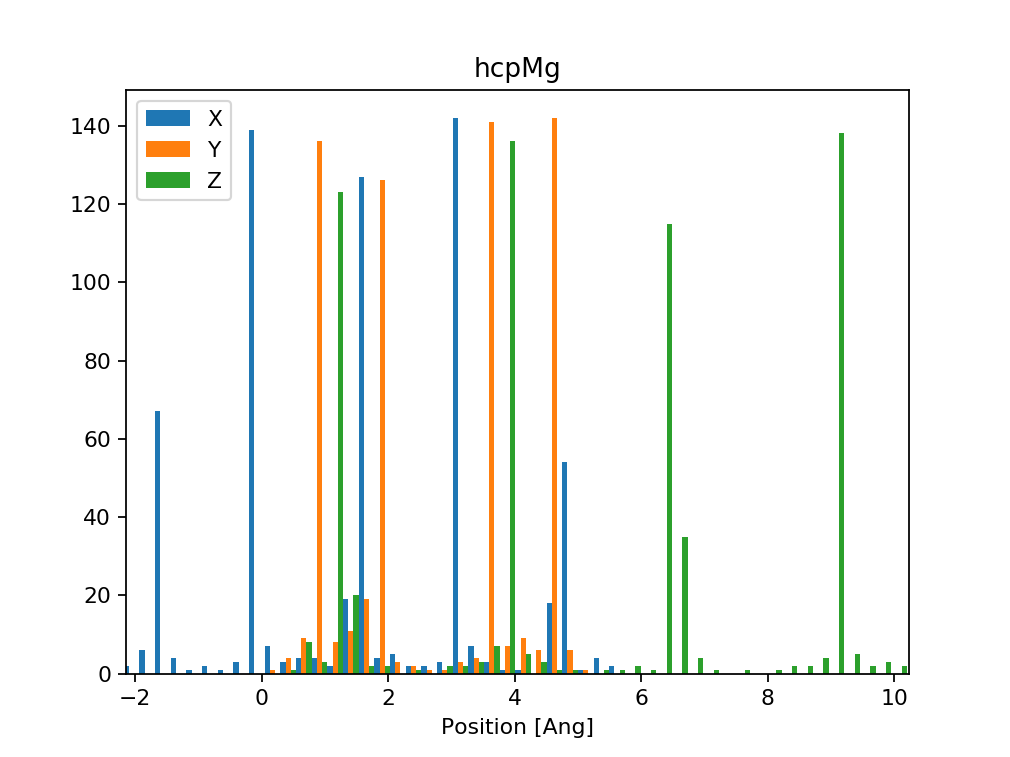

<IPython.core.display.Javascript object>


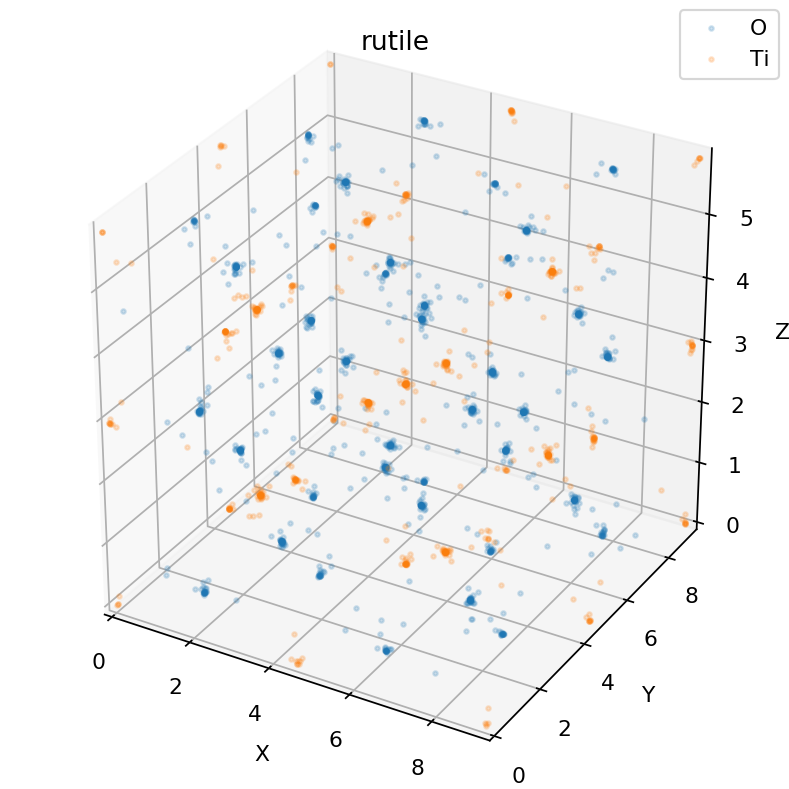

<IPython.core.display.Javascript object>


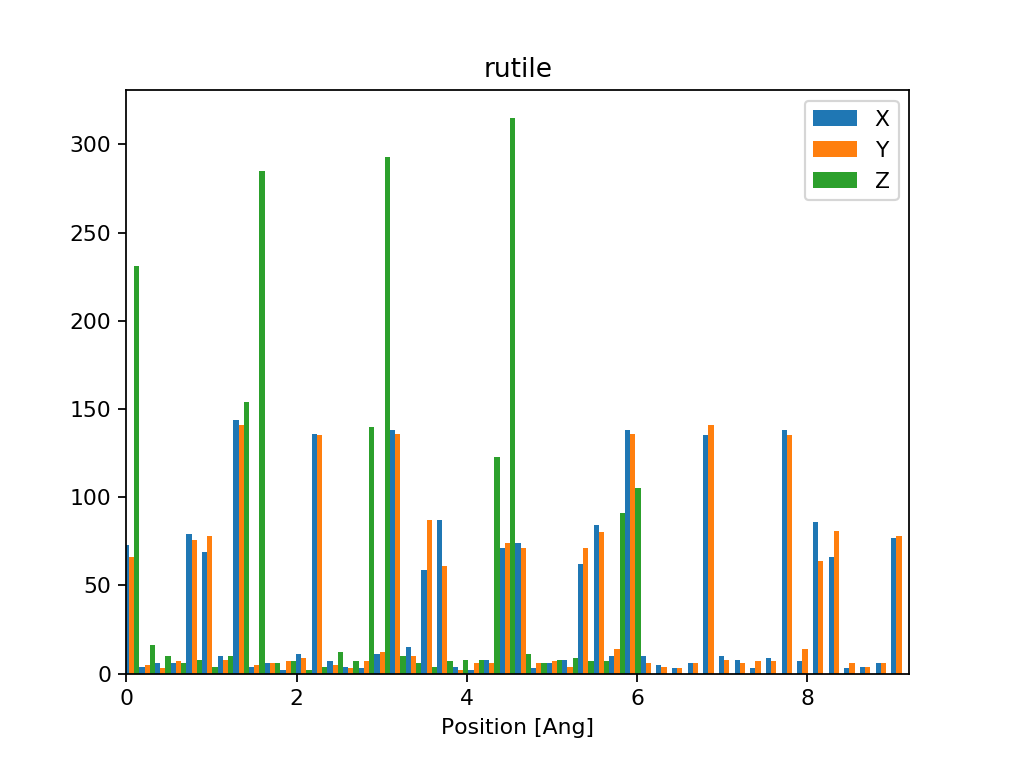

<IPython.core.display.Javascript object>


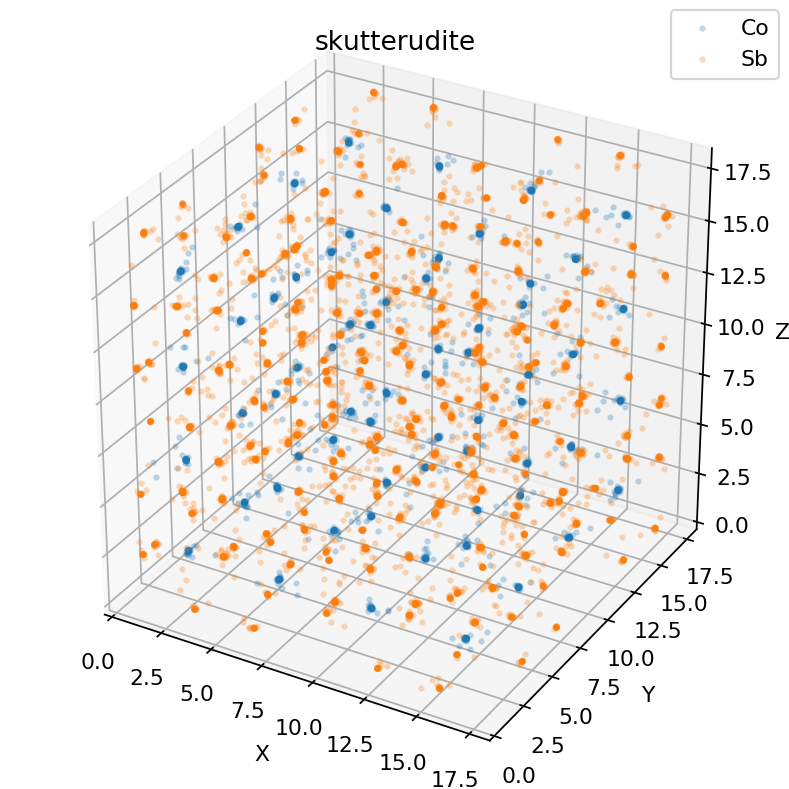

<IPython.core.display.Javascript object>


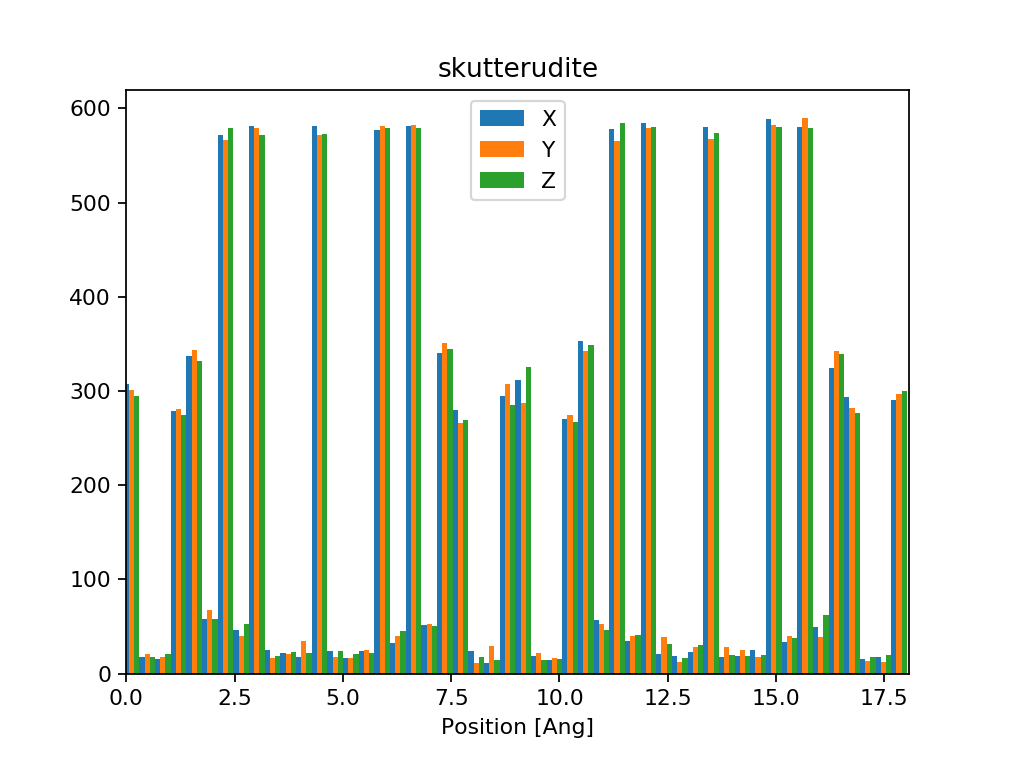

In [3]:
Nrattle = 5
rattle_rvs = [stats.norm(loc=0,scale=.001), stats.norm(loc=0,scale=.005),\
              stats.norm(loc=0,scale=.01), stats.norm(loc=0,scale=.02),\
              stats.norm(loc=0,scale=.03), stats.norm(loc=0,scale=.05),\
               stats.norm(loc=0,scale=.1), stats.norm(loc=0,scale=.5)]
CRs = [atb.CrystalRattler(rattle_rv=rattle_rv) for rattle_rv in rattle_rvs]

rpositions, Natoms, cells, species = None, None, None, None
crystal_names = []
all_rattled_positions = dict()
t_l = []
for sname in sorted(atoms_dict):
    print("rattling ",sname)
    rpositions, Natoms, cells, species = atb.rattle_crystal_multiple_rvs(Nrattle, rattle_rvs,\
                                atoms_dict[sname], rpositions=rpositions, Natoms=Natoms,\
                                species=species, cells=cells)
    t_l.append([sname for v in range(Nrattle*len(rattle_rvs)*atoms_dict[sname].positions.shape[0])])
    crystal_names.extend([sname for v in range(Nrattle*len(rattle_rvs))])
    
rpositions_flat, Natoms_flat, cells_flat, species_flat = atb.flattening_rattled_crystal_data(rpositions,\
                                                    Natoms, cells, species)
t_l_flat = np.hstack(t_l)
print("t_l_flat {}".format(len(t_l_flat)))
print("rpositions_flat {}, Natoms_flat {} atoms total {}, cells_flat {}, species_flat {}".format(len(rpositions_flat), len(Natoms_flat), sum(Natoms_flat), len(cells_flat), len(species_flat)))

Nrvs = len(rattle_rvs)
for i,sname in enumerate(sorted(atoms_dict)):
    atoms = atoms_dict[sname]
    markersizes = {_k:2 for _k in set(atoms.get_chemical_symbols())}
    
    _rpositions = rpositions_flat[i*Nrvs*Nrattle:(i+1)*Nrvs*Nrattle]
    _species = species_flat[i*Nrvs*Nrattle:(i+1)*Nrvs*Nrattle]
    _cells = cells_flat[i*Nrvs*Nrattle:(i+1)*Nrvs*Nrattle]
            
    atb.show_rattled_atoms(_rpositions, species=_species,
                       cells=_cells, markersizes=markersizes, title=sname)

## 3. Setting up Design Matrices

In [4]:
all_filter = lambda s,s_ref: np.array([True for v in range(s.shape[0])])
like_filter = lambda s,s_ref: s == s_ref
unlike_filter = lambda s,s_ref: s != s_ref

r_cut = 4.

# tbaf_params = {"k":20,"_range":(0,np.pi),"normed":True,"element_filter":all_filter}
bopf_params = {"k":[4,6],"element_filter":all_filter,"kind":"1"}
bopf_params_like = {"k":[4,6],"element_filter":like_filter,"kind":"1"}
bopf_params_unlike = {"k":[4,6],"element_filter":unlike_filter,"kind":"1"}
# dtf_params = {"taper_fun":atb.taper_fun_wrapper(_type="x4ge",a=r_cut,b=1.),"element_filter":all_filter}
# detf_params = {"taper_fun":atb.taper_fun_wrapper(_type="x4ge",a=r_cut,b=1.),"element_filter":all_filter,
#                "rs_":[0.,1.],"eta_":[1.,1.]}
# dctf_params = {"taper_fun":atb.taper_fun_wrapper(_type="x4ge",a=r_cut,b=1.),"element_filter":all_filter,
#                "kappa_":[1.,2.]}
# dcetf3body_params = {"taper_fun":atb.taper_fun_wrapper(_type="x4ge",a=r_cut,b=1.),"element_filter":all_filter,
#                      "xi_":[0.,1.],"lambda_":[1.,1.],"eta_":[1.,.5]}
# dcetf3body2_params = {"taper_fun":atb.taper_fun_wrapper(_type="x4ge",a=r_cut,b=1.),"element_filter":all_filter,
#                       "xi_":[0.,1.],"lambda_":[1.,1.],"eta_":[1.,.5]}

# featurers = [atb.ThreeBodyAngleFeatures, atb.BondOrderParameterFeatures,
#              atb.DistanceTaperingFeatures_2body, atb.DistanceExpTaperingFeatures_2body,
#              atb.DistanceCosTaperingFeatures_2body, atb.DistanceCosExpTaperingFeatures_3body,
#              atb.DistanceCosExpTaperingFeatures_3body2,]

#featurer_params = [tbaf_params, bopf_params, dtf_params, detf_params, dctf_params,
#                    dcetf3body_params, dcetf3body2_params]

featurers = [atb.BondOrderParameterFeatures, atb.BondOrderParameterFeatures,
             atb.BondOrderParameterFeatures,]
featurer_params = [bopf_params, bopf_params_like, bopf_params_unlike]

for i in range(len(rpositions_flat)): # looping rattle rv & crystal type
    if i%10==0:
        print("\n{}/{}".format(i+1,len(rpositions_flat)))
    print("crystal ",crystal_names[i])
    _pos = rpositions_flat[i]
    _cell = cells_flat[i]
    _spec = species_flat[i]

    _Phi = atb.get_crystal_design_matrix(positions=_pos, species=_spec, cell=_cell, r_cut=r_cut, 
                                    features_class=featurers,
                                    params_features=featurer_params, return_force=False)
    
    assert np.isfinite(_Phi).all(), "_Phi contains non-finite values."
    if i == 0:
        Phi = np.copy(_Phi)
    else:
        Phi = np.vstack((Phi,_Phi))
    print("Phi ",Phi.shape)


1/320
crystal  NaCl
Phi  (64, 6)
crystal  NaCl
Phi  (128, 6)
crystal  NaCl
Phi  (192, 6)
crystal  NaCl
Phi  (256, 6)
crystal  NaCl
Phi  (320, 6)
crystal  NaCl
Phi  (384, 6)
crystal  NaCl
Phi  (448, 6)
crystal  NaCl
Phi  (512, 6)
crystal  NaCl
Phi  (576, 6)
crystal  NaCl
Phi  (640, 6)

11/320
crystal  NaCl
Phi  (704, 6)
crystal  NaCl
Phi  (768, 6)
crystal  NaCl
Phi  (832, 6)
crystal  NaCl
Phi  (896, 6)
crystal  NaCl
Phi  (960, 6)
crystal  NaCl
Phi  (1024, 6)
crystal  NaCl
Phi  (1088, 6)
crystal  NaCl
Phi  (1152, 6)
crystal  NaCl
Phi  (1216, 6)
crystal  NaCl
Phi  (1280, 6)

21/320
crystal  NaCl
Phi  (1344, 6)
crystal  NaCl
Phi  (1408, 6)
crystal  NaCl
Phi  (1472, 6)
crystal  NaCl
Phi  (1536, 6)
crystal  NaCl
Phi  (1600, 6)
crystal  NaCl
Phi  (1664, 6)
crystal  NaCl
Phi  (1728, 6)
crystal  NaCl
Phi  (1792, 6)
crystal  NaCl
Phi  (1856, 6)
crystal  NaCl
Phi  (1920, 6)

31/320
crystal  NaCl
Phi  (1984, 6)
crystal  NaCl
Phi  (2048, 6)
crystal  NaCl
Phi  (2112, 6)
crystal  NaCl
Phi  (2176, 6)

Phi  (9824, 6)
crystal  rutile
Phi  (9872, 6)
crystal  rutile
Phi  (9920, 6)

261/320
crystal  rutile
Phi  (9968, 6)
crystal  rutile
Phi  (10016, 6)
crystal  rutile
Phi  (10064, 6)
crystal  rutile
Phi  (10112, 6)
crystal  rutile
Phi  (10160, 6)
crystal  rutile
Phi  (10208, 6)
crystal  rutile
Phi  (10256, 6)
crystal  rutile
Phi  (10304, 6)
crystal  rutile
Phi  (10352, 6)
crystal  rutile
Phi  (10400, 6)

271/320
crystal  rutile
Phi  (10448, 6)
crystal  rutile
Phi  (10496, 6)
crystal  rutile
Phi  (10544, 6)
crystal  rutile
Phi  (10592, 6)
crystal  rutile
Phi  (10640, 6)
crystal  rutile
Phi  (10688, 6)
crystal  rutile
Phi  (10736, 6)
crystal  rutile
Phi  (10784, 6)
crystal  rutile
Phi  (10832, 6)
crystal  rutile
Phi  (10880, 6)

281/320
crystal  skutterudite
Phi  (11136, 6)
crystal  skutterudite
Phi  (11392, 6)
crystal  skutterudite
Phi  (11648, 6)
crystal  skutterudite
Phi  (11904, 6)
crystal  skutterudite
Phi  (12160, 6)
crystal  skutterudite
Phi  (12416, 6)
crystal  skutterudite
Phi  (1

## 4. Generating Labeling & Split into Test and Train Sets

In [5]:
label_map = {k:i for i,k in enumerate(sorted(atoms_dict))}
t = np.array([label_map[v] for v in t_l_flat])
t = np.array(t,dtype=int)
print("\nfinal sizes: t = {}, Phi = {}".format(t.shape,Phi.shape))

Phi_train, Phi_test, t_train, t_test = \
        train_test_split(Phi, t, test_size=.4, random_state=42)
print("train sizes: t = {}, Phi = {}".format(t_train.shape,Phi_train.shape))
print("test sizes: t = {}, Phi = {}".format(t_test.shape,Phi_test.shape))


final sizes: t = (21120,), Phi = (21120, 6)
train sizes: t = (12672,), Phi = (12672, 6)
test sizes: t = (8448,), Phi = (8448, 6)


## 5. Plotting Things

<IPython.core.display.Javascript object>


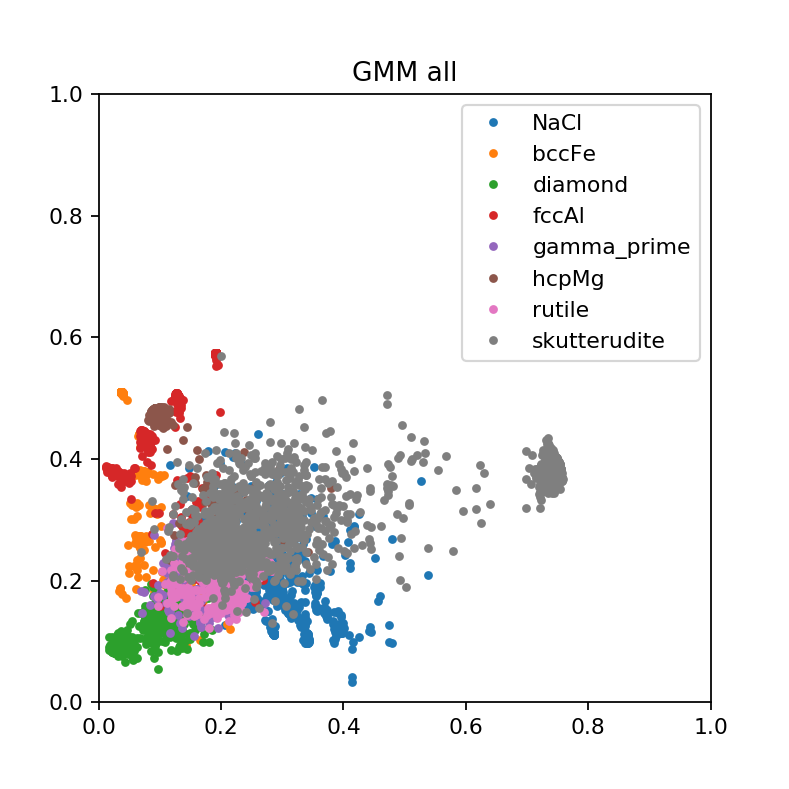

<IPython.core.display.Javascript object>


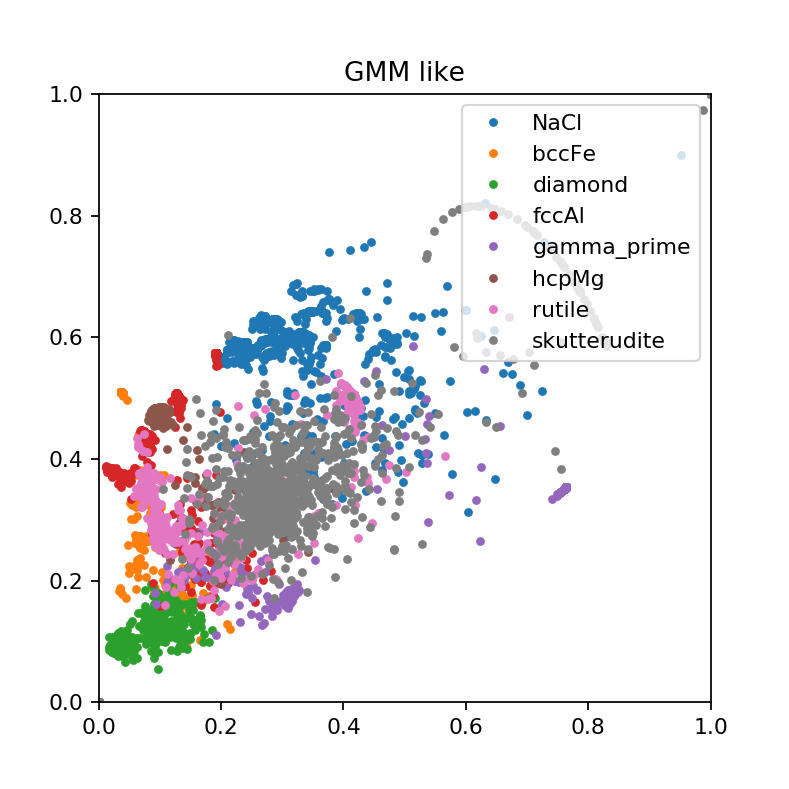

<IPython.core.display.Javascript object>


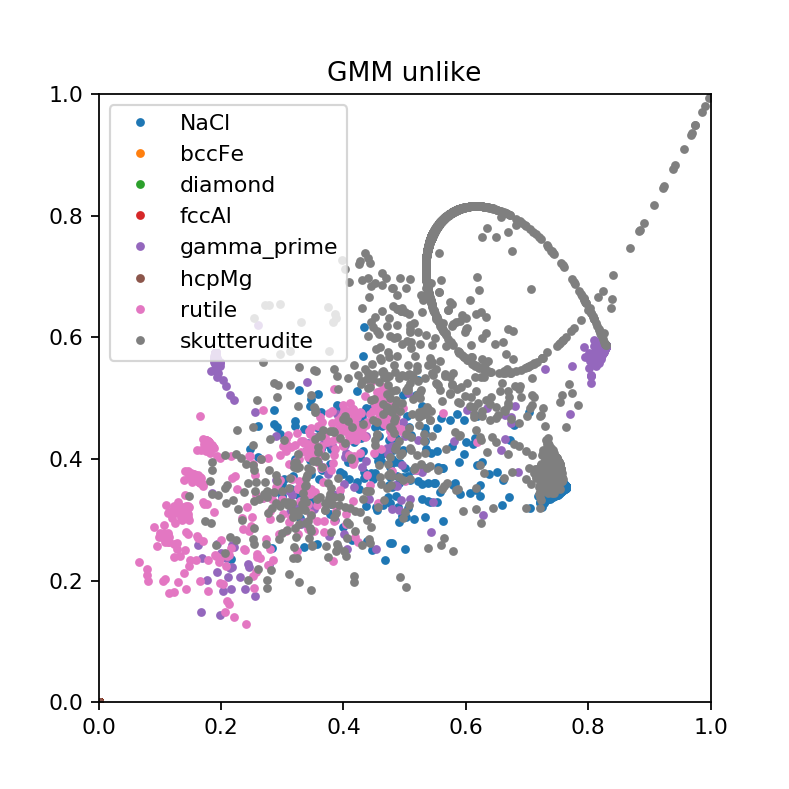

In [6]:
idx_class = {k:np.where(t_train==k)[0] for k in np.unique(t_train)}

xlim, ylim = (0,1), (0,1)
x, y = np.linspace(xlim[0],xlim[1],1000), np.linspace(ylim[0],ylim[1],1000)
xgrid, ygrid = np.meshgrid(x,y,indexing="ij")
X_plot = np.array([xgrid.ravel(), ygrid.ravel()]).T
s = xgrid.shape

# all
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)

for slabel in sorted(atoms_dict):
    label = label_map[slabel]
    ix = idx_class[label]
    X = Phi_train[ix,:]    
    ax.plot(X[:,0], X[:,1],'.',label=slabel)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_title("GMM all")
plt.legend(loc=0)
plt.show()

# like
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)

for slabel in sorted(atoms_dict):
    label = label_map[slabel]
    ix = idx_class[label]
    X = Phi_train[ix,:]    
    ax.plot(X[:,2], X[:,3],'.',label=slabel)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_title("GMM like")
plt.legend(loc=0)
plt.show()

# unlike
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)

for slabel in sorted(atoms_dict):
    label = label_map[slabel]
    ix = idx_class[label]
    X = Phi_train[ix,:]    
    ax.plot(X[:,4], X[:,5],'.',label=slabel)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_title("GMM unlike")
plt.legend(loc=0)
plt.show()

## 6. Gaussian Mixture Based Classification

Example with various classifiers, standardization and test/train splits: http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html

### 6.1 Fit Gaussian Mixtures

Commonly GMM are used to approximate the complete distribution of all classes in feature space. The individual Gaussians are then related to the individual classes. Instead we approximate here the feature space distribution for each class individually with a set of Gaussians. These approximations are then used to compare classes for a new position in feature space.

In [8]:
vgmm = BayesianGaussianMixture(n_components=5, weight_concentration_prior=1., 
                               covariance_type="full")
gmc = atb.GaussianMixtureClassifier(gmm=vgmm)
gmc.fit(Phi_train, t_train)

E:\Programs\Anaconda3\envs\py35\lib\site-packages\sklearn\mixture\base.py:237: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


### 6.2 Store Classifier

In [9]:
save_path = "BayesianGaussianMixtureClassifier.pckl"
gmc.save(save_path)

### 6.3 Load Classifier

In [10]:
load_path = "BayesianGaussianMixtureClassifier.pckl"
gmc_load = atb.GaussianMixtureClassifier(load_path=load_path)

### 6.4 Classification Reports for Test and Train sets

In [11]:
print("\nTrain\n----")
print(sklearn.metrics.classification_report(t_train,gmc.predict(Phi_train), 
                                      target_names=sorted(atoms_dict.keys())))

print("\nTest\n----")
print(sklearn.metrics.classification_report(t_test,gmc.predict(Phi_test), 
                                      target_names=sorted(atoms_dict.keys())))


Train
----
              precision    recall  f1-score   support

        NaCl       0.96      0.99      0.97      1559
       bccFe       0.81      0.92      0.86       381
     diamond       0.99      0.98      0.99      1524
       fccAl       0.96      0.90      0.93       766
 gamma_prime       0.95      0.98      0.96       739
       hcpMg       0.95      0.97      0.96       363
      rutile       0.98      0.98      0.98      1147
skutterudite       1.00      0.99      0.99      6193

 avg / total       0.98      0.98      0.98     12672


Test
----
              precision    recall  f1-score   support

        NaCl       0.96      0.99      0.97      1001
       bccFe       0.83      0.91      0.87       259
     diamond       1.00      0.98      0.99      1036
       fccAl       0.92      0.94      0.93       514
 gamma_prime       0.94      0.98      0.96       541
       hcpMg       0.96      0.92      0.94       277
      rutile       0.98      0.97      0.98       773
s

In [12]:
print("\nTrain\n----")
print(sklearn.metrics.classification_report(t_train,gmc_load.predict(Phi_train), 
                                      target_names=sorted(atoms_dict.keys())))

print("\nTest\n----")
print(sklearn.metrics.classification_report(t_test,gmc_load.predict(Phi_test), 
                                      target_names=sorted(atoms_dict.keys())))


Train
----
              precision    recall  f1-score   support

        NaCl       0.96      0.99      0.97      1559
       bccFe       0.81      0.92      0.86       381
     diamond       0.99      0.98      0.99      1524
       fccAl       0.96      0.90      0.93       766
 gamma_prime       0.95      0.98      0.96       739
       hcpMg       0.95      0.97      0.96       363
      rutile       0.98      0.98      0.98      1147
skutterudite       1.00      0.99      0.99      6193

 avg / total       0.98      0.98      0.98     12672


Test
----
              precision    recall  f1-score   support

        NaCl       0.96      0.99      0.97      1001
       bccFe       0.83      0.91      0.87       259
     diamond       1.00      0.98      0.99      1036
       fccAl       0.92      0.94      0.93       514
 gamma_prime       0.94      0.98      0.96       541
       hcpMg       0.96      0.92      0.94       277
      rutile       0.98      0.97      0.98       773
s